In [1]:
from google.colab import drive
drive.mount("mnt")

Drive already mounted at mnt; to attempt to forcibly remount, call drive.mount("mnt", force_remount=True).


In [2]:
%cd "mnt/My Drive/LSTM"

/content/mnt/My Drive/LSTM


In [3]:
import numpy as np
from numpy import sin, cos
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
def gen_array(dataset):
    X, Y = [], []
    for i in range(np.size(dataset) - 2):
        X.append(dataset[i])
        Y.append(dataset[i+1])
    return np.array(X), np.array(Y)

In [5]:
angle1 = 120
angle2 = 0
G = 9.81  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

dt = 0.01
t = np.arange(0.0, 100 , dt)
state = np.radians([angle1, 0, angle2, 0])
y = integrate.odeint(derivs, state, t)
x1 = 1 * sin(y[:, 0])
y1 = -1 * cos(y[:, 0])
x2 = 1 * sin(y[:, 2]) + x1
y2 = -1 * cos(y[:, 2]) + y1

In [6]:
data = np.transpose([x2]).astype('float32')
# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# lookback
trainX, trainY = gen_array(data)
# reshape
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [7]:
model = Sequential()
model.add(LSTM(8, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(trainX, trainY, validation_split=0.33, epochs=50, batch_size=1, verbose=2, validation_steps=30)

Epoch 1/50
6698/6698 - 28s - loss: 0.0154 - mean_squared_error: 0.0562 - val_loss: 1.8367e-06 - val_mean_squared_error: 0.0154
Epoch 2/50
6698/6698 - 8s - loss: 1.0266e-04 - mean_squared_error: 0.0107 - val_loss: 3.0914e-05 - val_mean_squared_error: 0.0077
Epoch 3/50
6698/6698 - 8s - loss: 9.6269e-05 - mean_squared_error: 0.0063 - val_loss: 8.0489e-05 - val_mean_squared_error: 0.0052
Epoch 4/50
6698/6698 - 8s - loss: 9.1907e-05 - mean_squared_error: 0.0045 - val_loss: 3.1606e-06 - val_mean_squared_error: 0.0039
Epoch 5/50
6698/6698 - 8s - loss: 8.8284e-05 - mean_squared_error: 0.0035 - val_loss: 3.1780e-06 - val_mean_squared_error: 0.0031
Epoch 6/50
6698/6698 - 8s - loss: 8.4567e-05 - mean_squared_error: 0.0029 - val_loss: 1.2945e-05 - val_mean_squared_error: 0.0026
Epoch 7/50
6698/6698 - 8s - loss: 8.4059e-05 - mean_squared_error: 0.0024 - val_loss: 4.1910e-05 - val_mean_squared_error: 0.0023
Epoch 8/50
6698/6698 - 8s - loss: 8.3079e-05 - mean_squared_error: 0.0021 - val_loss: 3.0385e

In [8]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


In [9]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

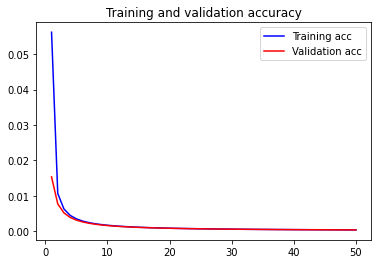

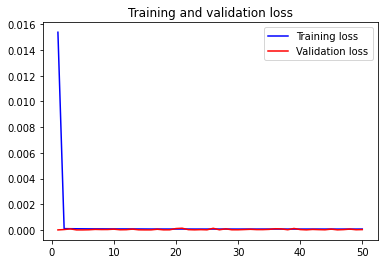

In [10]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
!mkdir -p saved_model_x
model.save("/content/mnt/My Drive/LSTM/saved_model_x") 

INFO:tensorflow:Assets written to: /content/mnt/My Drive/LSTM/saved_model_x/assets


INFO:tensorflow:Assets written to: /content/mnt/My Drive/LSTM/saved_model_x/assets


In [132]:
new_angle1=0.05
new_t = np.arange(0, 200 , dt)
new_state = np.radians([new_angle1, 0, angle2, 0])
new_y = integrate.odeint(derivs, new_state, new_t)
new_x1 = 1 * sin(new_y[:, 0])
new_y1 = -1 * cos(new_y[:, 0])
new_x2 = 1 * sin(new_y[:, 2]) + new_x1
new_y2 = -1 * cos(new_y[:, 2]) + new_y1

In [133]:
new_data = np.transpose([new_x2]).astype('float32')
# normalize
new_data = scaler.fit_transform(new_data)
# lookback
new_trainX, new_trainY = gen_array(new_data)
# reshape
new_trainX = np.reshape(new_trainX, (new_trainX.shape[0], 1, new_trainX.shape[1]))

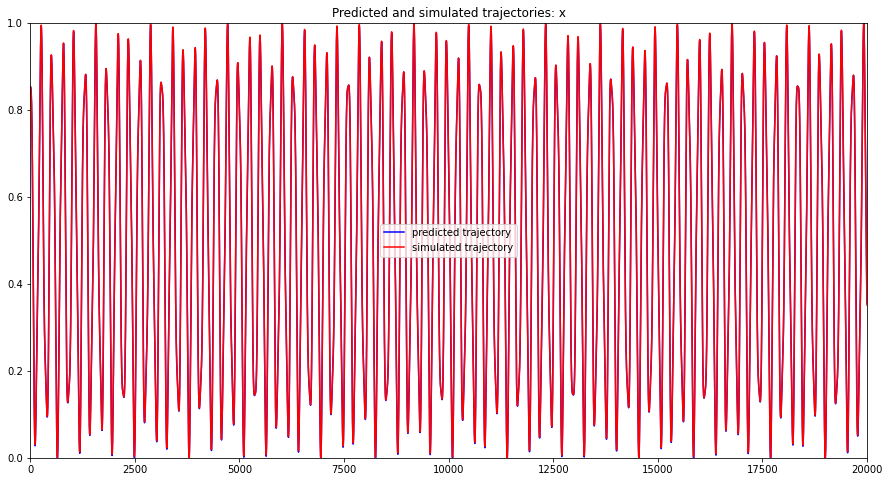

In [134]:
prediction = model.predict(new_trainX)

ax = plt.subplot(1,1,1)
ax.set_xlim(0,20000)
ax.set_ylim(0,1)
plt.plot(prediction, 'b', label='predicted trajectory')
plt.plot(new_trainY, 'r', label='simulated trajectory')
plt.title('Predicted and simulated trajectories: x')
plt.legend()

fig = ax.figure
fig.set_figwidth(15)
fig.set_figheight(8)
plt.show()

In [135]:
np.savetxt('predictionX0.txt', prediction)

In [136]:
np.savetxt('newtrainX0.txt', new_trainY)